# Preprocessing and Annotation of Inflation Perturbation Data

In [1]:
%matplotlib inline

import os
import helper_functions_GSE164638 as hf

import scanpy as sc
import pandas as pd
import numpy as np
import scipy.io
import scipy.sparse as ssp
import matplotlib.pyplot as plt

<div class="alert alert-info">
    
# Navigating this notebook
*** ***    
**Input/Output & Parameters**
0. [Directories and Defining parameters](#step0)
1. [Load data and make output folders](#load_data)
    <br>
    <br>
    
**Filtering: mitochondrial, ribosomal, ncRNA gene high cells**
2. [Filtering cells based on mitochondrial gene expression](#mito_filter)
3. [Filtering cells based on ribosomal genes](#ribo_filter)
4. [Filtering cells with higher than average expression of subset of non-coding RNA genes](#ncrna_filter)
5. [Summary of # barcodes (cells) pre-filter and post-filter](#bc_summary)
    <br>
    <br>

**Preprocessing for visualization**
6. [Preprocessing: normalization, logarithmizing, choosing highly variable genes](#pp_norm_log_hvg) 
7. [Annotate cells for cell cycle scores](#cc_phases)
8. [Preprocessing: Z-score the log-transformed counts matrix, reduce dimensionality, cluster, and visualize](#pp_z_score_log_pca_leiden_umap)
    <br>
    <br>
    
**Annotating cell states**
9. [Classify cells based on marker gene scores](#annotation)
10. [Coarse grained states - Figure 6A](#6A)
11. [Plot each treatment cluster - Figure S4A](#S4A)
    <br>
    <br>
    
**Save files**
12. [Save data files](#save_all)
13. [Export to SPRING](#spring)
    
</div>  

*** ***

<a id='step0'></a>

## Directories for input and output data

In [2]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)

# for plots from matplotlib, seaborn, helper functions plots:
plot_dir = '_plots_preprocessing'
os.makedirs(plot_dir, exist_ok=True)

spring_main='_spring'
os.makedirs(spring_main, exist_ok=True)

## Set up export formatting for scanpy figures

In [3]:
# look for the folder "figures"
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                     frameon=True, vector_friendly=True, fontsize=14, 
                     figsize=None, color_map=None, format='eps', 
                     facecolor=None, transparent=False, ipython_format='png2x')

<a id='load_data'></a>

## Load/Save Count Data from/into h5ad files 

In [4]:
# To load the filtered files at a later point:
sample_list = ['F12-1.1', 'D12-1.2', 'C36-2.1', 'D36-2.2']
D = {}
for s in sample_list:
    D[s] = sc.read(f'{h5ad_dir}/{s}-filtered.h5ad')
gene_list = D[s].var_names.values.astype(str)

In [5]:
# merge anndata objects into one object
adata = sc.AnnData.concatenate(
    *[D[s] for s in sample_list], 
    batch_key='Library Name',
    batch_categories=sample_list
)

In [6]:
def gene_list_lowercase(adata):
    adata_gene_lower = []
    for gene_name in adata.var_names:
        gene_name = gene_name.lower()
        adata_gene_lower.append(gene_name)
    adata.var_names = adata_gene_lower

In [7]:
# keep all genes lowercase
# keep in mind for loading lists of genes later on
gene_list_lowercase(adata)

In [8]:
# 6924 cells x 40931 genes
adata.X

<6924x40931 sparse matrix of type '<class 'numpy.float32'>'
	with 9468037 stored elements in Compressed Sparse Row format>

In [9]:
# use scanpy's quality control metrics and store in AnnData object for later reference
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [10]:
# write as an AnnData file to recover before preprocessing if you ever need it
sc.write(f'{h5ad_dir}/adata_merged_raw_perturbations.h5ad', adata)

... storing 'treatment' as categorical
... storing 'duration' as categorical


*** ***

<a id='mito_filter'></a>

## Filtering cells based on mitochondrial gene expression 

In [11]:
# define mitochondrial genes
mito_genes = adata.var_names.str.startswith(("mt-"))
print(sum(mito_genes))

37


In [12]:
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add % mitochondrial genes per cell to .obs DataFrame in AnnData object
adata.obs['percent_mito'] = np.sum(
    ssp.csc_matrix(adata[:, mito_genes].X), axis=1).A1 / np.sum(ssp.csc_matrix(adata.X), axis=1).A1

# add the total counts per cell to .obs DataFrame in AnnData object
adata.obs['n_counts'] = ssp.csc_matrix(adata.X).sum(axis=1).A1

#sense-check
print(len(adata.var_names[mito_genes]))

37


### Plot fraction of UMIs belonging to mitochondrial genes for cells in dataset

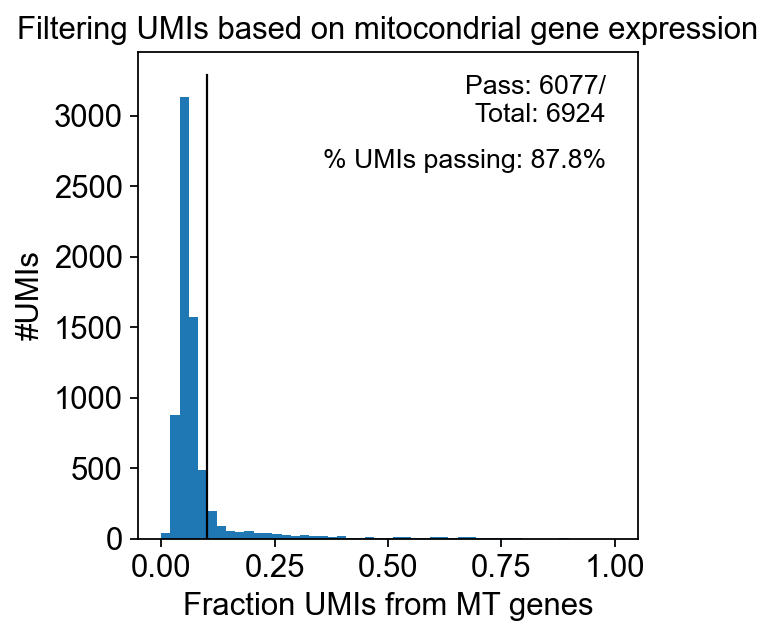

<Figure size 320x320 with 0 Axes>

In [13]:
# max fraction of UMIs coming from mitochondrial genes
max_mt = 0.1

adata.obs['mito_frac'] = adata.X[:, mito_genes].A.sum(1) / adata.obs['n_counts']
    
plt.hist(adata.obs['mito_frac'], np.linspace(0, 1, 50))

xl = np.array([0,1])
yl = np.array(plt.ylim())

plt.plot([max_mt,max_mt], yl, c='black', linewidth=1)
plt.grid(False)

ntot = len(adata.obs['mito_frac'])
npass = sum(adata.obs['mito_frac'] <= max_mt)


plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.9, 'Pass: {}/\n Total: {}'.format(npass, ntot), fontsize=12, ha='right')
plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.8, '% UMIs passing: {:.1f}%'.format(npass/ntot*100), fontsize=12, ha='right')

plt.title('Filtering UMIs based on mitocondrial gene expression')
plt.xlabel('Fraction UMIs from MT genes')
plt.ylabel('#UMIs')

plt.show()
plt.show()

plt.savefig(f'{plot_dir}/umis_passing_after_mito_{max_mt}_perturbations.eps')

In [14]:
# save % mitochondrial gene expression for library as a dictionary for plotting later
pct_mito = {}
for lib_name in adata.obs['Library Name'].unique():
    pct_mito[lib_name] = np.around(adata.obs.loc[adata.obs['Library Name'] == lib_name]['percent_mito'].mean()*100, 2)

<a id='ribo_filter'></a>

## Filtering cells based on ribosomal genes

In [15]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("rps","rpl", "malat1"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    ssp.csc_matrix(adata[:, ribo_genes].X), axis=1).A1 / np.sum(ssp.csc_matrix(adata.X), axis=1).A1

106


### Plot fraction of UMIs belonging to ribosomal genes for all cells

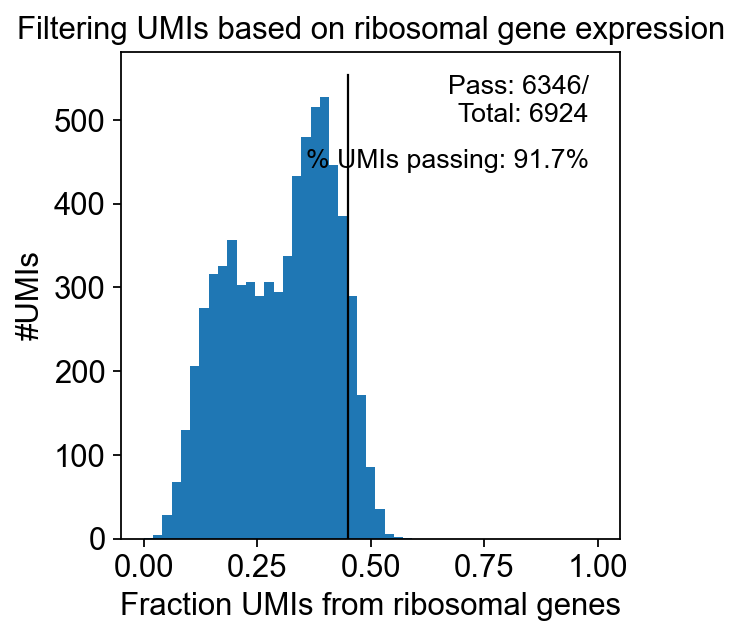

<Figure size 320x320 with 0 Axes>

In [16]:
# max fraction of UMIs coming from ribosomal genes
max_ribo = 0.45

adata.obs['ribo_frac'] = adata.X[:,ribo_genes].A.sum(1) / adata.obs['n_counts']
    
plt.hist(adata.obs['ribo_frac'], np.linspace(0, 1, 50))

xl = np.array([0,1])
yl = np.array(plt.ylim())

plt.plot([max_ribo,max_ribo], yl, c='black', linewidth=1)
plt.grid(False)

ntot = len(adata.obs['ribo_frac'])
npass = sum(adata.obs['ribo_frac'] <= max_ribo)


plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.9, 'Pass: {}/\n Total: {}'.format(npass, ntot), fontsize=12, ha='right')
plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.8, '% UMIs passing: {:.1f}%'.format(npass/ntot*100), fontsize=12, ha='right')

plt.title('Filtering UMIs based on ribosomal gene expression')
plt.xlabel('Fraction UMIs from ribosomal genes')
plt.ylabel('#UMIs')

plt.show()
plt.show()

plt.savefig(f'{plot_dir}/umis_passing_after_ribo_{max_ribo}_perturbations.eps')

In [17]:
pct_ribo = {}
for lib_name in adata.obs['Library Name'].unique():
    pct_ribo[lib_name] = np.around(adata.obs.loc[adata.obs['Library Name'] == lib_name]['percent_ribo'].median()*100, 2)

<a id='ncrna_filter'></a>

## Filtering cells with higher than average expression of subset of non-coding RNA genes
##### Added after finding a small cluster (~20 cells) with high ncRNA; which we believe is an artifact of the template-switching method we have used for this dataset

In [18]:
# get ncRNA genes 
# this is probably an artifact of the switch drops method, as per Ignas Mazelis' unpublished work
ncrna_genes = ['gm26917', 'gm42418', 'gm25580', 'gm24139', 'gm24146']

In [19]:
# subset of ncRNAs found to be highly expressed in small subset of cells
ncrna_genes = adata.var_names.str.startswith(('gm26917', 'gm42418', 'gm25580', 'gm24139', 'gm24146'))
print(sum(ncrna_genes))

5


In [20]:
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_ncrna'] = np.sum(
    ssp.csc_matrix(adata[:, ncrna_genes].X), axis=1).A1 / np.sum(ssp.csc_matrix(adata.X), axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = ssp.csc_matrix(adata.X).sum(axis=1).A1

### Plot fraction of UMIs belonging to subset of ncRNA genes for all cells

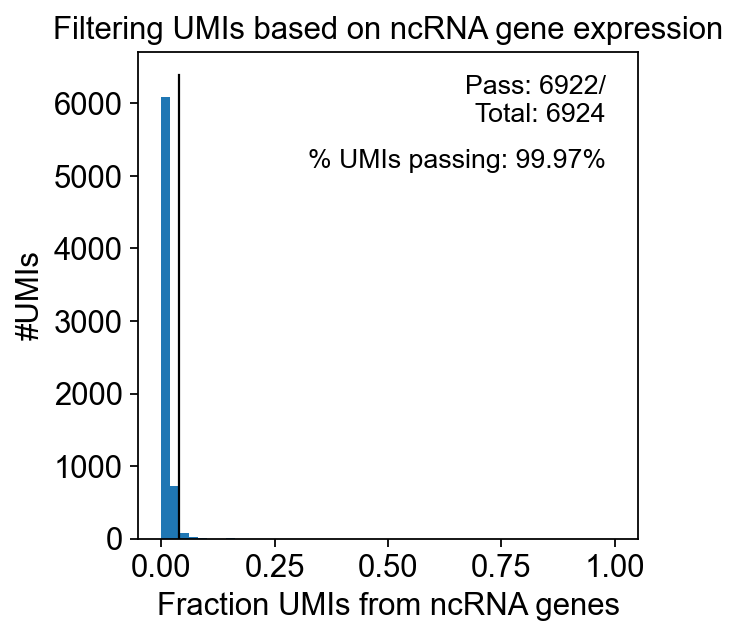

<Figure size 320x320 with 0 Axes>

In [21]:
# max fraction of UMIs coming from ncRNA genes
# chosen based on exclusion of small susbet of ncRNA high cells, without removing other cells
# after several iterations through to clustering and visualization
max_ncrna = 0.04

adata.obs['ncrna_frac'] = adata.X[:, ncrna_genes].A.sum(1) / adata.obs['n_counts']
    
plt.hist(adata.obs['ncrna_frac'], np.linspace(0, 1, 50))

xl = np.array([0,1])
yl = np.array(plt.ylim())

plt.plot([max_ncrna,max_ncrna], yl, c='black', linewidth=1)
plt.grid(False)

ntot = len(adata.obs['ncrna_frac'])
npass = sum(adata.obs['ncrna_frac'] <= max_mt)


plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.9, 'Pass: {}/\n Total: {}'.format(npass, ntot), fontsize=12, ha='right')
plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.8, '% UMIs passing: {:.2f}%'.format(npass/ntot*100), fontsize=12, ha='right')

plt.title('Filtering UMIs based on ncRNA gene expression')
plt.xlabel('Fraction UMIs from ncRNA genes')
plt.ylabel('#UMIs')

plt.show()
plt.show()

plt.savefig(f'{plot_dir}/umis_passing_after_ncrna_{max_ncrna}_perturbations.eps')

### Plot all three metrics as violin plots for visualizing across treatments
##### Note that the DMSO samples separate by % ncRNA, but not % mitochondrial genes or ribosomal genes

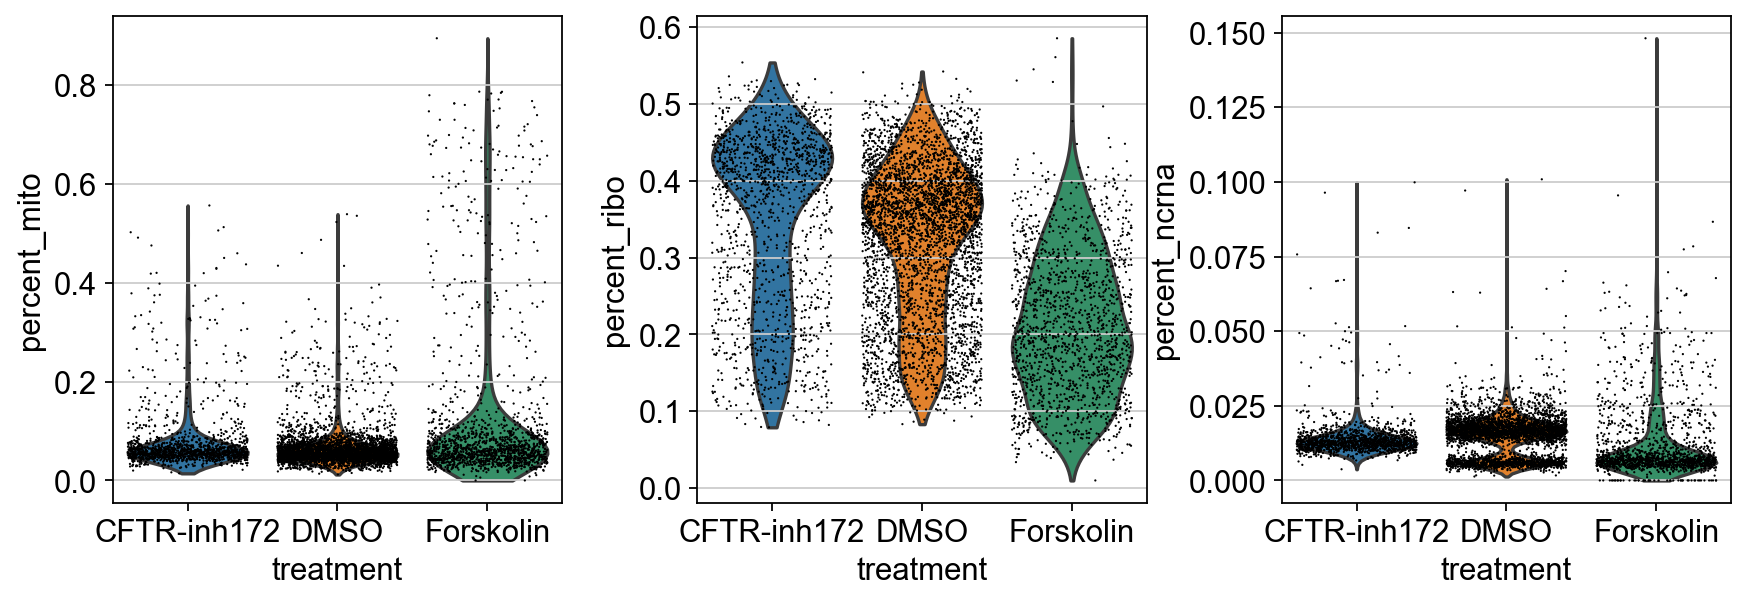

In [22]:
sc.pl.violin(adata, ['percent_mito','percent_ribo', 'percent_ncrna'],
             jitter=0.4, groupby = 'treatment', save='_violin_plots_by_treatment_perturbations')


### Visualize metrics with scatter plots for each library, instead of treatment 

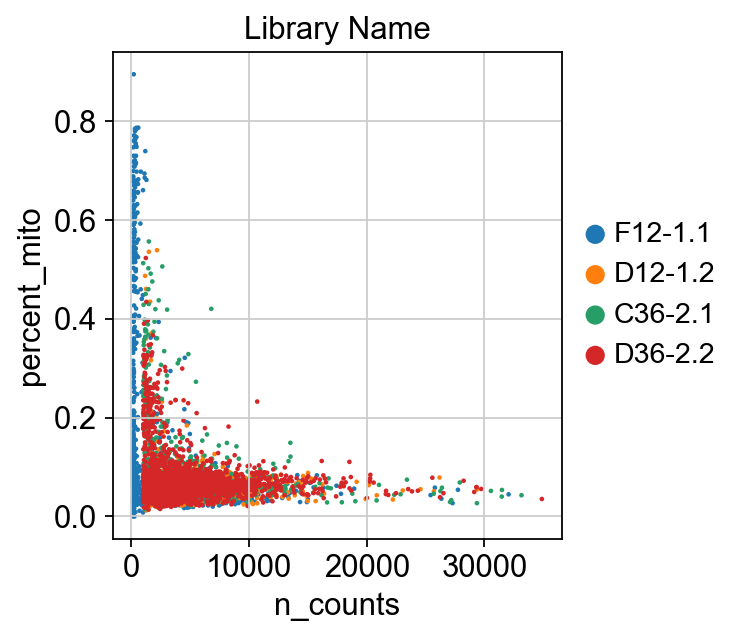

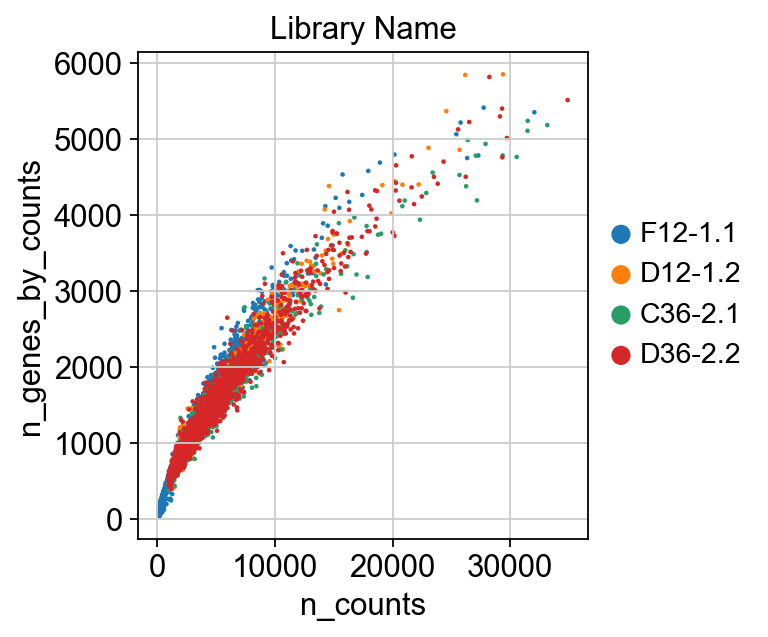

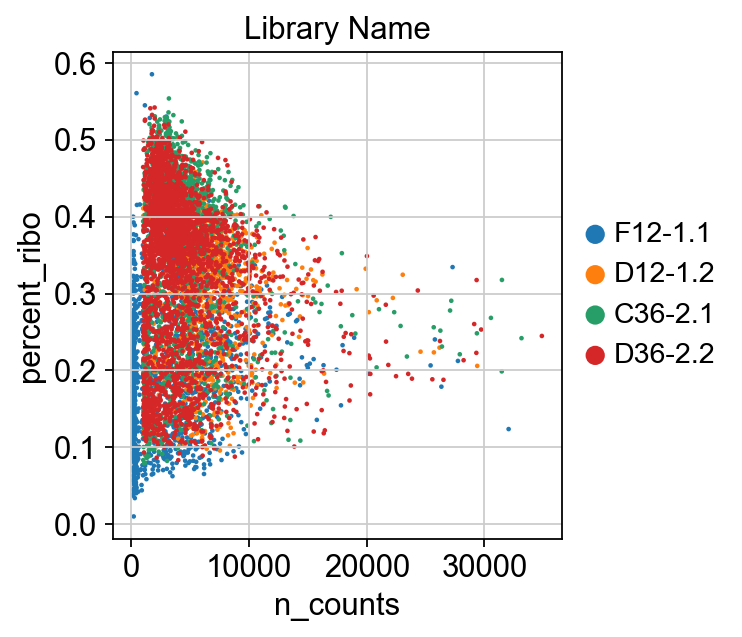

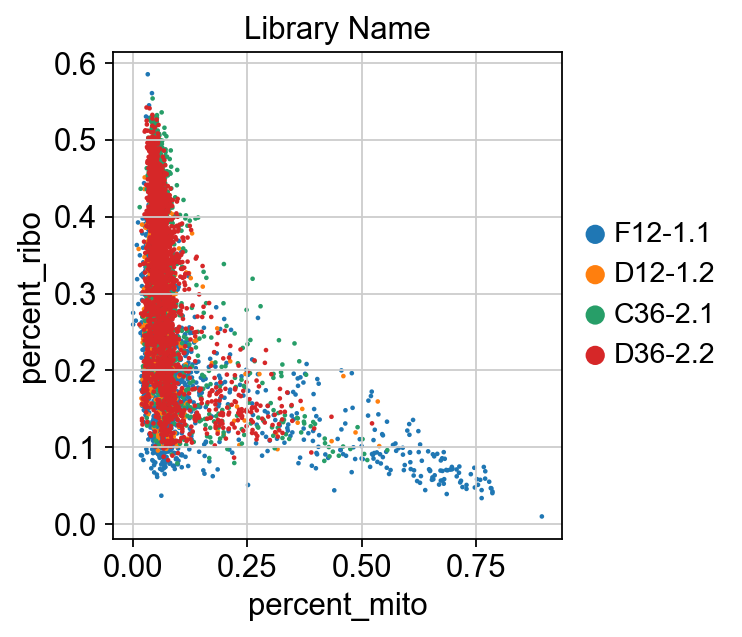

In [23]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color="Library Name", save='pct_mito_perturbations')
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color="Library Name", save='genes_by_counts_perturbations')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color="Library Name", save='pct_ribo_perturbations')
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color="Library Name", save='pct_ribo_v_pct_mito_perturbations')

In [24]:
# save as dictionary for later
gbc = {}
for lib_name in adata.obs['Library Name'].unique():
    gbc[lib_name] = np.format_float_scientific(adata.obs.loc[adata.obs['Library Name'] == lib_name]['n_genes_by_counts'].mean()*100)

<a id='bc_summary'></a>

## Summary of # barcodes (cells) pre-filter and post-filter 

In [25]:
print('Sample\t\t\t# barcodes pre-filter\t\t# barcodes post-filter')

s = 'Merged'
n_orig = adata.shape[0]
adata = adata[adata.obs['mito_frac'] <= max_mt]
adata = adata[adata.obs['ribo_frac'] <= max_ribo]
adata = adata[adata.obs['ncrna_frac'] <= max_ncrna]

# one more filtering step
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

n_pass = adata.shape[0]
print('{:20s}\t{}\t\t\t\t{}'.format(s, n_orig, n_pass))

Sample			# barcodes pre-filter		# barcodes post-filter
Merged              	6924				5241


In [26]:
adata.raw = adata # save the filtered adata with the counts matrix untouched!!

*** ***

<a id='pp_norm_log_hvg'></a>

## Preprocessing: Normalization, logarithmizing, choosing highly variable genes

In [27]:
# Total count normalize to CP10K - this overwrites X!
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) 

In [28]:
# sense check
print('before normalization:', adata.raw[1000].X.sum())
print('after normalization:', adata[1000].X.sum())

before normalization: 6669.0
after normalization: 9999.926


In [29]:
# log-transform the counts matrix
sc.pp.log1p(adata)

In [30]:
# calculate highly variable genes based on parameters below
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=8, min_disp=0.5)

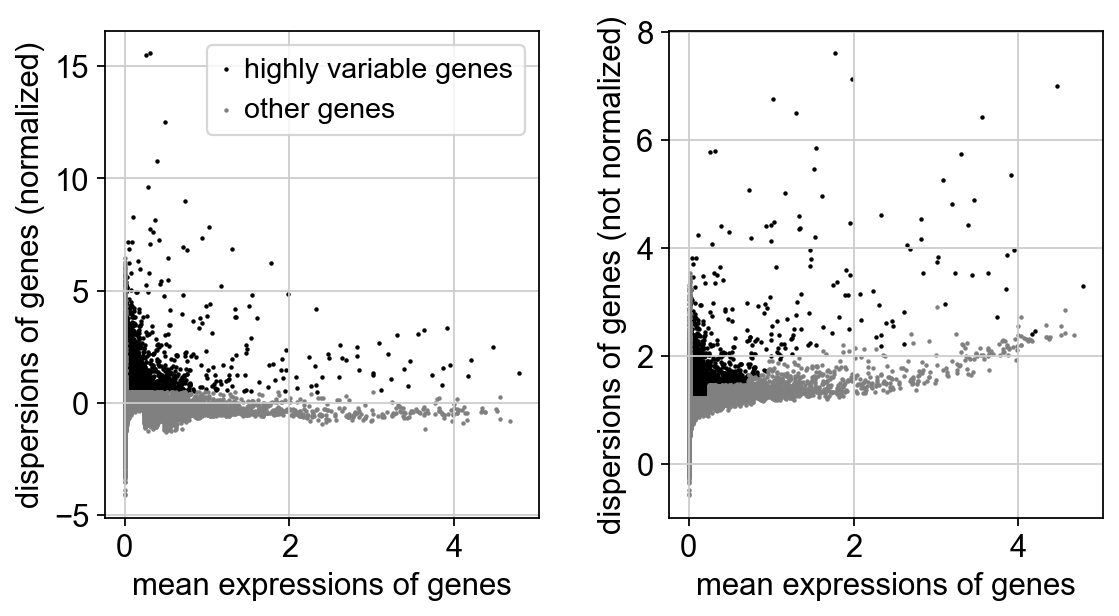

In [31]:
sc.pl.highly_variable_genes(adata)

In [32]:
len(adata.var.loc[adata.var['highly_variable'] == True])

4513

In [33]:
# lgr5 and lyz1 should make it onto this list - let's double-check
print('lgr5 highly variable?:', adata.var[adata.var.index == 'lgr5']['highly_variable'].values)
print('lyz1 highly variable?:', adata.var[adata.var.index == 'lyz1']['highly_variable'].values)

lgr5 highly variable?: [ True]
lyz1 highly variable?: [ True]


<a id='cc_phases'></a>

## Annotate cells for cell cycle scores

#### Use cell cycle genes from [Tirosh and Izar et al., 2016](https://science.sciencemag.org/content/352/6282/189/tab-figures-data)

In [34]:
mouse_g2_m = pd.read_excel('cell_cycle_g2m.xlsx')

In [35]:
mouse_g1_s = pd.read_excel('cell_cycle_g1s.xlsx')

In [36]:
cc_g1s = []

for gene in list(mouse_g1_s['external_gene_name']): 
    if isinstance(gene, str) == True:
        if gene.lower() in adata.var_names:
            cc_g1s.append(gene.strip(' ').lower())

In [37]:
cc_g2m = []

for gene in list(mouse_g2_m['external_gene_name']): 
    if isinstance(gene, str) == True:
        if gene.lower() in adata.var_names:
            cc_g2m.append(gene.strip(' ').lower())

In [38]:
adata.var_names.unique()
sc.tl.score_genes_cell_cycle(adata, s_genes=cc_g1s, g2m_genes=cc_g2m)

In [39]:
cell_cycle_genes = [x for x in cc_g1s if x in adata.var_names] + [x for x in cc_g2m if x in adata.var_names]

... storing 'phase' as categorical


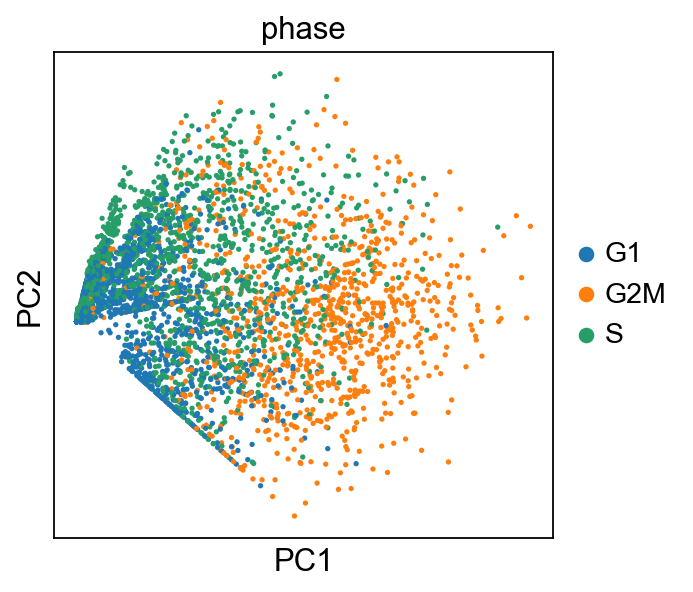

In [40]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

<a id='pp_z_score_log_pca_leiden_umap'></a>

## Preprocessing: Z-score the log-transformed counts matrix, reduce dimensionality, cluster, and visualize

In [41]:
# z-score the data before running PCA
sc.pp.scale(adata)

### Dimensionality reduction: PCA

In [42]:
# run PCA
sc.pp.pca(adata, n_comps=11)

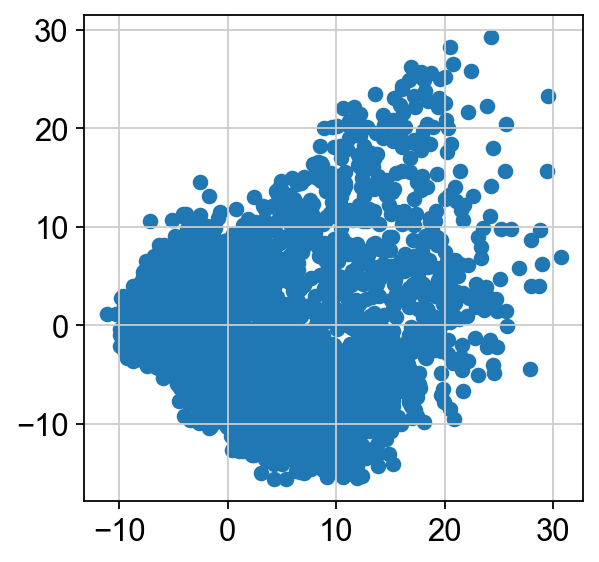

In [43]:
# plot the first two components as a sense-check
plt.scatter(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1])

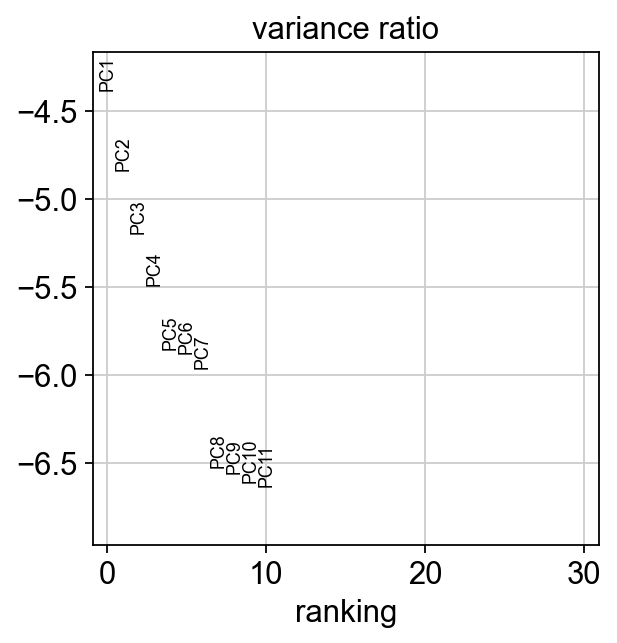

In [44]:
# use the elbow rule, iterating over different n_comps to choose # PCs
sc.pl.pca_variance_ratio(adata, log=True)

### Get neighborhood graph

In [45]:
# set the number of neighbors for neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10)

### Leiden clustering

In [46]:
# setting number of neighbors will affect the the leiden clustering
sc.tl.leiden(adata, resolution=0.12)

# tune resolution so that you can clearly see a reasonable number of clusters for the timepoint
cluster_number = len(adata.obs['leiden'].cat.categories)
print(f'Number of clusters: {cluster_number}')

Number of clusters: 6


### Visualization with UMAP

In [47]:
# embed neighborhood graph with UMAP
sc.tl.umap(adata, random_state=1234124) 

/Users/hailey/Dropbox (HMS)/Organoids_shared/ Organoid paper 2021/_THIRD SUBMISSION - MARCH 2021/GSE164638_scRNA-seq/helper_functions_GSE164638.py:321: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[~ix], y[~ix], s=point_size, c=[[.8,.8,.8]], edgecolors = '')
/Users/hailey/Dropbox (HMS)/Organoids_shared/ Organoid paper 2021/_THIRD SUBMISSION - MARCH 2021/GSE164638_scRNA-seq/helper_functions_GSE164638.py:322: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[ix], y[ix], s=point_size, c=[[0,0,0]], edgecolors = '')


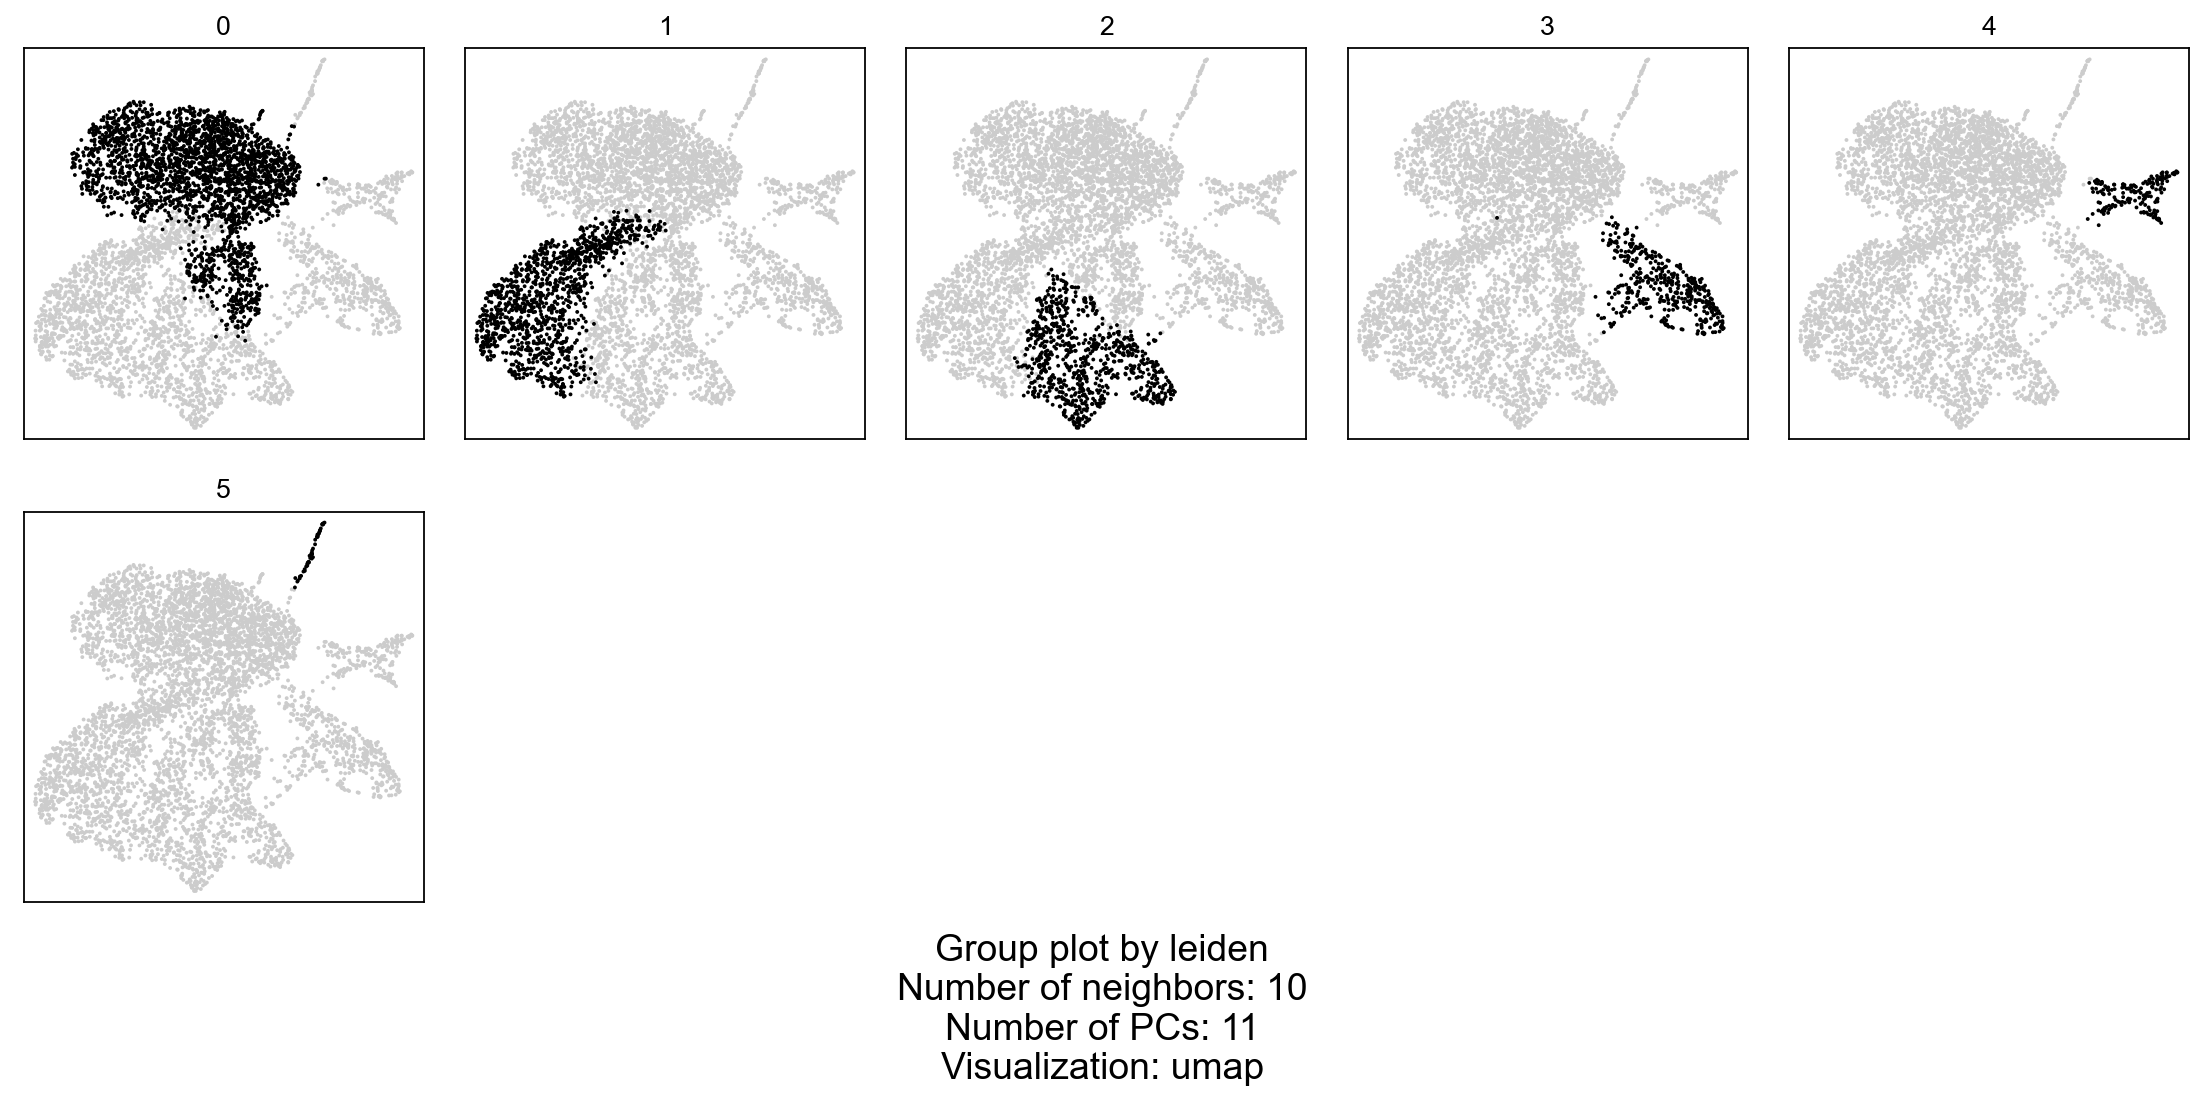

In [48]:
# visualize each cluster individually across dataset
hf.plot_processing(adata, adata.obsm['X_umap'], 'leiden')
plt.show()

### Plot clusters, cell cycle phase scores, cell cycle markers, and total counts

In [49]:
# reset figure parameters for optimal viewing
plt.rcParams['figure.figsize'] = (5, 5)

... storing 'phase' as categorical


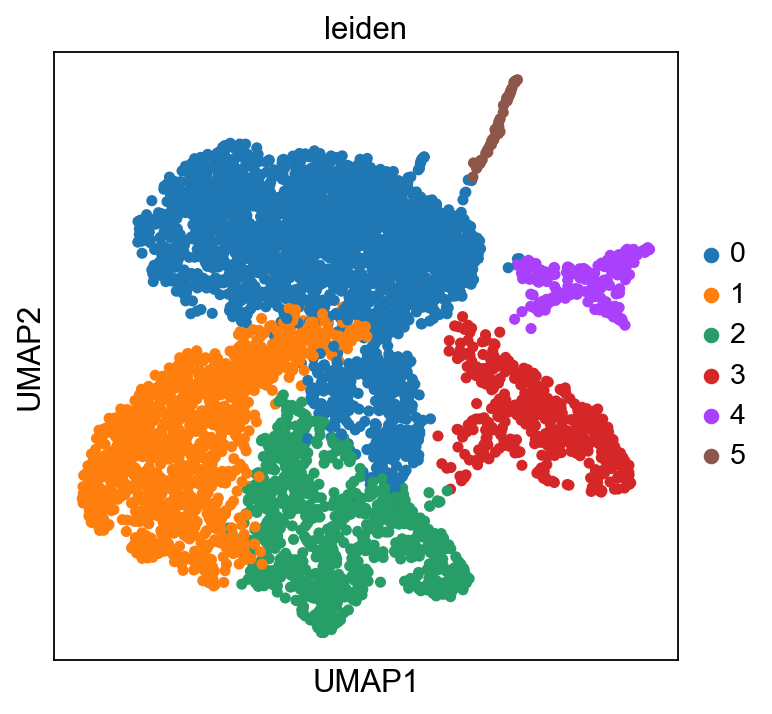

In [50]:
sc.pl.umap(adata, color='leiden', s=100, save='merged_leiden_perturbations')

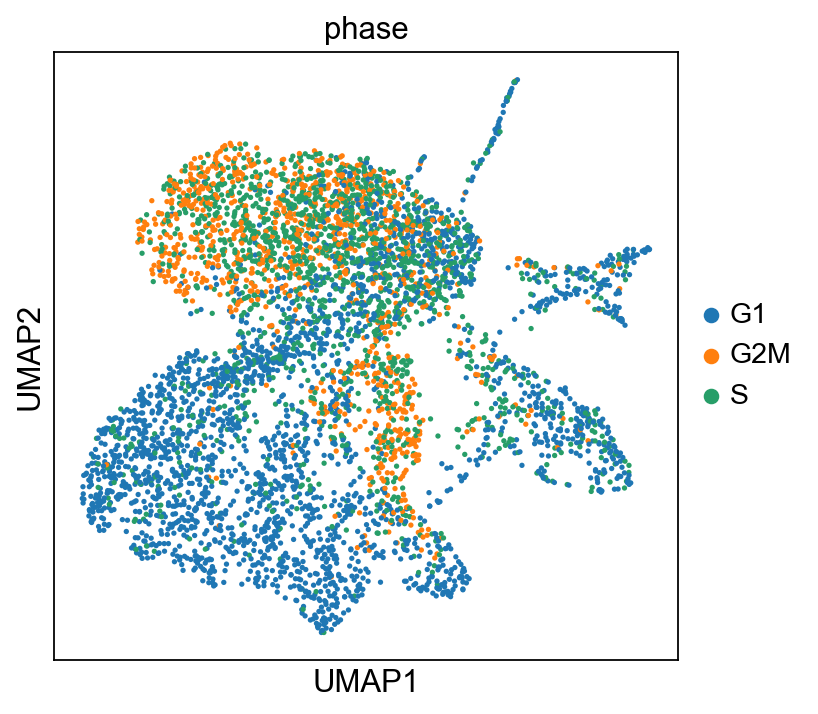

In [51]:
sc.pl.umap(adata, color='phase', save='_cell_cycle_phase_perturbations')

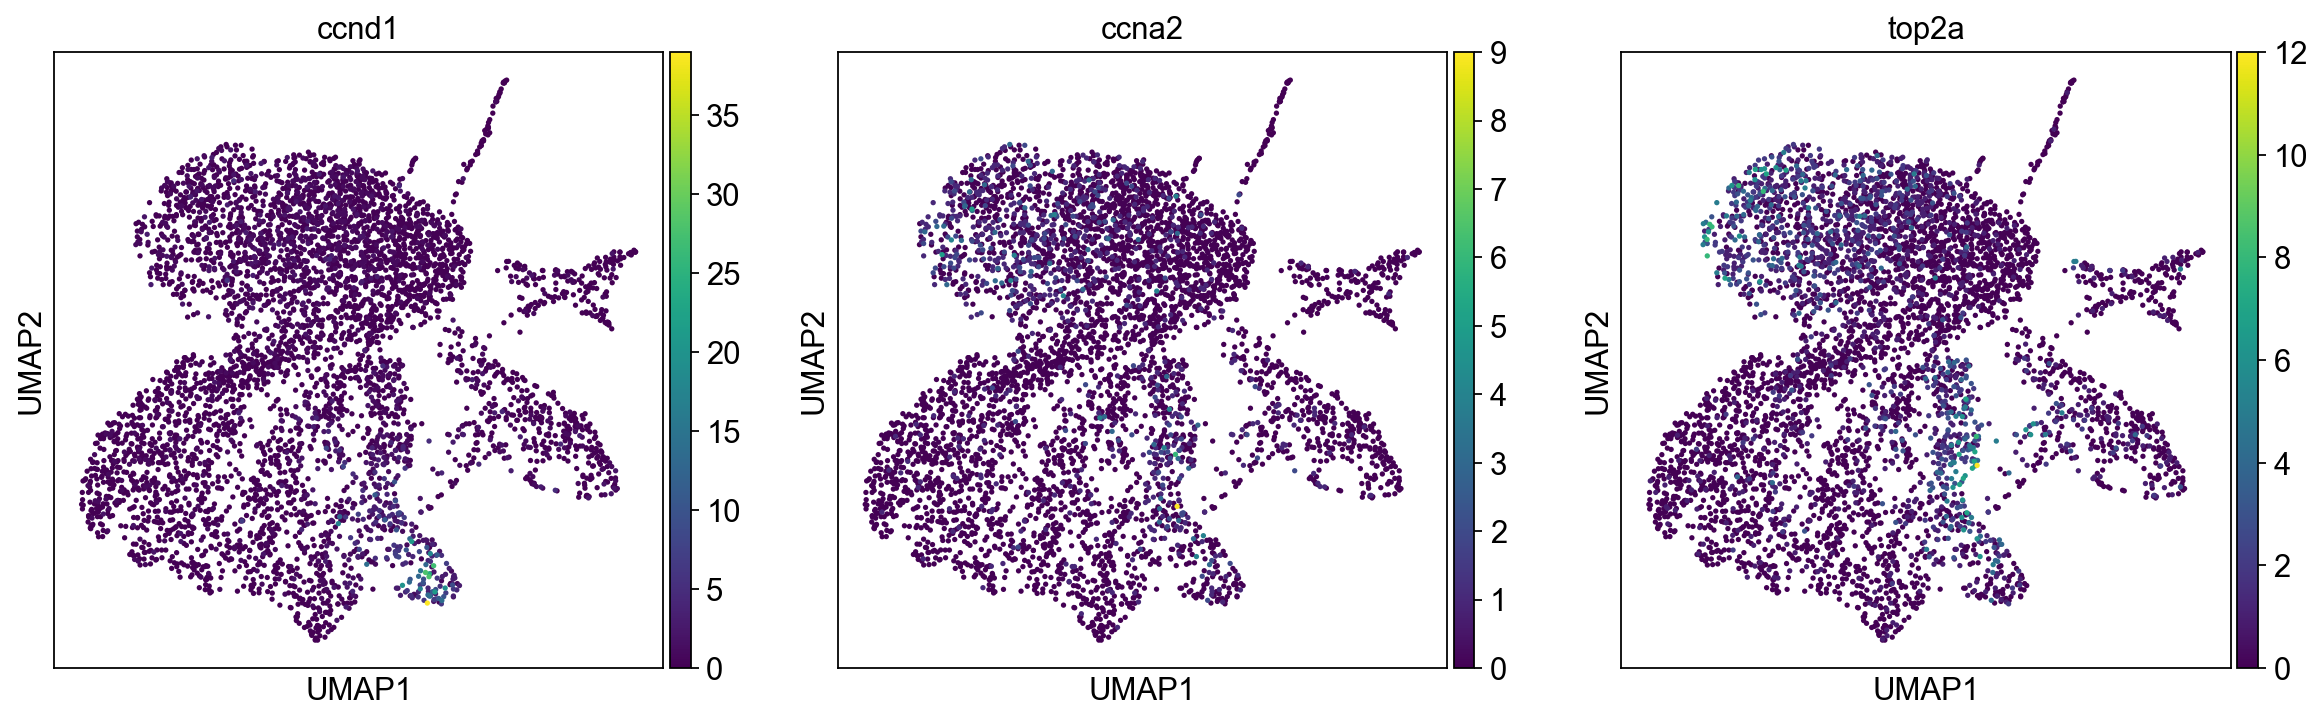

In [52]:
sc.pl.umap(adata, color=['ccnd1', 'ccna2', 'top2a'], save='_cell_cycle_markers_perturbations')

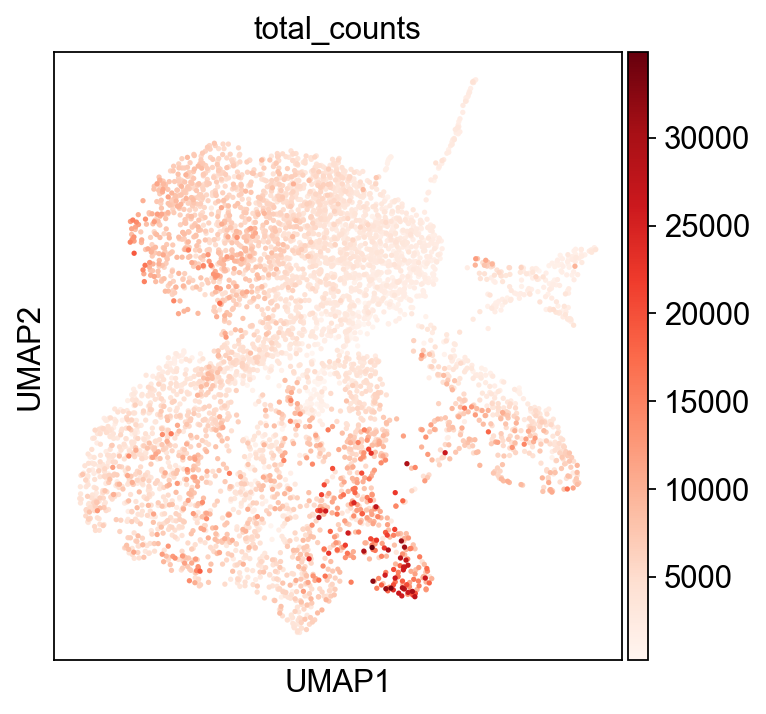

In [53]:
sc.pl.umap(adata, color='total_counts', cmap='Reds', save='_total_counts_perturbations')

<a id='annotation'></a>

## Classify cells based on marker gene scores

In [54]:
#read in differentially expressedmg_dict genes
df_exp_gene_xl = pd.read_excel('marker_genes_used_for_annotation.xlsx')

In [55]:
del df_exp_gene_xl['Unnamed: 0'] # added when reading in excel with pandas

In [56]:
# create marker gene dictionary
mg_dict = {}
for state, mg_list in df_exp_gene_xl.items():
    mg_list_cleaned = [x for x in mg_list if str(x) != 'nan' and x in list(adata.var_names)]
    mg_dict[state] = mg_list_cleaned

In [57]:
# calculate scores for each cell
for state, mg_list in mg_dict.items():
    hf.calc_score_denserank(adata, f'state_marker_{state}', mg_dict[f'{state}'][0:100])

In [58]:
def classify_gene_score(adata, gene_score_prefix):
    '''
    Requires running 'calc_score_denserank' first to generate gene scores for each state based on the number of 
    marker genes chosen for that state.
    
    Arguments:
    ----------
    adata: AnnData object (scanpy)
        AnnData object to be classified
    gene_score_prefix: string
        string identifier for the gene score to use to classify the data; should not include the number of genes used
    ngenes: int
        number of marker genes used to calculate the gene score for a state; should match already calculated gene 
        score. 
    Returns:
    --------
    adata: AnnData object (scanpy)
        modifided AnnData object with newly added obs DataFrame with classified states based on marker gene scores.

    '''
    gene_score_dict = {}

    for groups in adata.obs:
        if groups.startswith(f'{gene_score_prefix}'):
            gene_score_dict[groups.split('_')[4]] = adata.obs[groups]
            print(groups.split('_')[4])
    gene_score_df = pd.DataFrame.from_dict(gene_score_dict)
    assign_state = gene_score_df.idxmax(axis=1)
    adata.obs[f'classify_{gene_score_prefix}']=np.array(assign_state)

In [59]:
classify_gene_score(adata, 'gene_score_state_marker_')

Enteroendocrine
Stem
Tuft
Stretch Signature
Enterocyte
Secretory


... storing 'classify_gene_score_state_marker_' as categorical


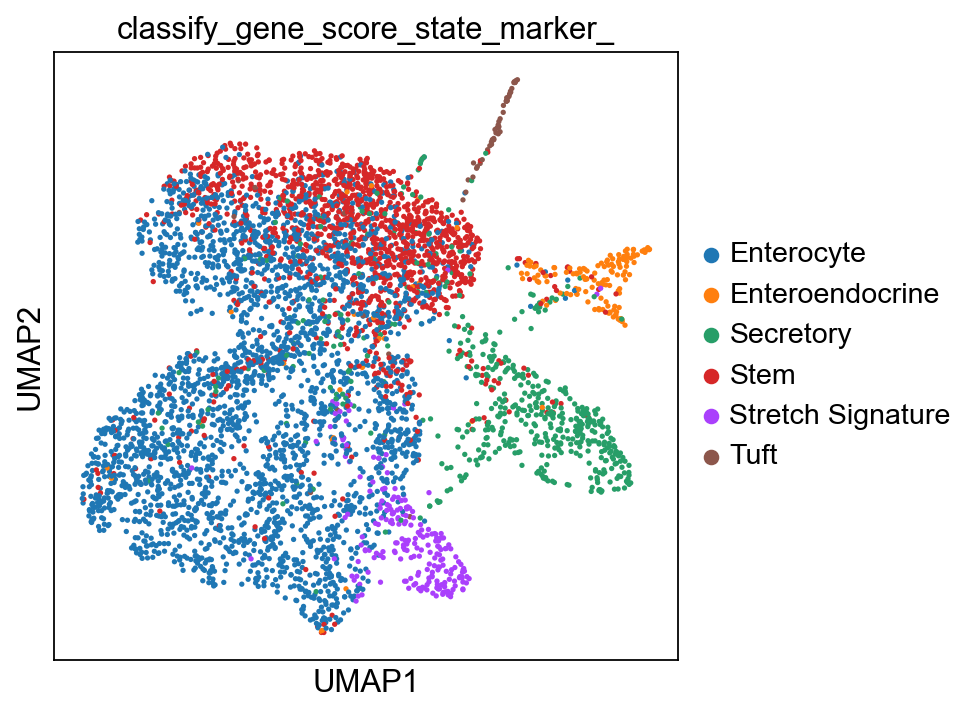

In [60]:
# plot cells with assigned identity based on individual gene expression
sc.pl.umap(adata, color='classify_gene_score_state_marker_', save='_merged_all_ref_mg_annotated_corrected_denserank_100mg_max_cbc_score_cell_states_perturbations')

### Coarse grain annotations based on cluster consensus

In [61]:
# annotate with more concise name
adata.obs['state'] = adata.obs['classify_gene_score_state_marker_']

In [62]:
def coarse_grain_classification(adata, state_group, cluster_group, threshold):
    #this function will coarse grain annotations based on the consensus in the cluster
    #the criteria is that any annotation with less than a fraction (threshold) 
    #of cells in the cluster is replaced with the majority annotation
    #Ex. suggest to use threshold = 0.1
    
    d_dict = {}
    
    n_cat = len(adata.obs[f'{cluster_group}'].cat.categories)
    
    # calculate the fraction of cells in each cluster in each state:
    for cluster in adata.obs[f'{cluster_group}'].cat.categories:
        cl_frac_state = {}
        num_cluster = (adata.obs[f'{cluster_group}'] == f'{cluster}').sum()
        for cat_ in adata.obs[f'{state_group}'].cat.categories:
            num_state = len(adata.obs[adata.obs[f'{cluster_group}'] == f'{cluster}'].loc[adata.obs[f'{state_group}'] == f'{cat_}'])
            cl_frac_state[cat_] = num_state/num_cluster # fraction of cells per state in each cluster
        d_dict[f'{cluster}'] = cl_frac_state
    
    # identify the max annotation per cluster, and annotations less than threshold
    cluster_annot = {}
    cluster_thresh = {}
    for cluster, dict_ in d_dict.items():
        cluster_df = pd.DataFrame.from_dict(dict_, orient='index')
        cluster_annot[cluster] = cluster_df.idxmax()
        cluster_thresh[cluster] = list(cluster_df[cluster_df[0] <= threshold].index)
    
            
    cluster_annot_df = pd.DataFrame.from_dict(cluster_annot)
    cluster_annot_df = cluster_annot_df.transpose()
    cluster_annot_df = cluster_annot_df.rename(columns={0: f'{state_group}'})
    
    #initialize so that the new column has old ids 
    adata.obs['state_coarse_grain'] = adata.obs['state'] #initialize so that the new column has old ids 
    
    for cluster in adata.obs[f'{cluster_group}'].unique():
        for state in cluster_thresh[cluster]:
            adata.obs[f'{state_group}_coarse_grain'].loc[(adata.obs[f'{state_group}'] == state) & \
                                                         (adata.obs[f'{cluster_group}'] == cluster)] \
            = cluster_annot_df[f'{state_group}'][cluster]

In [63]:
coarse_grain_classification(adata, 'state', 'leiden', 0.2)

### Plot the coarse grained cell states

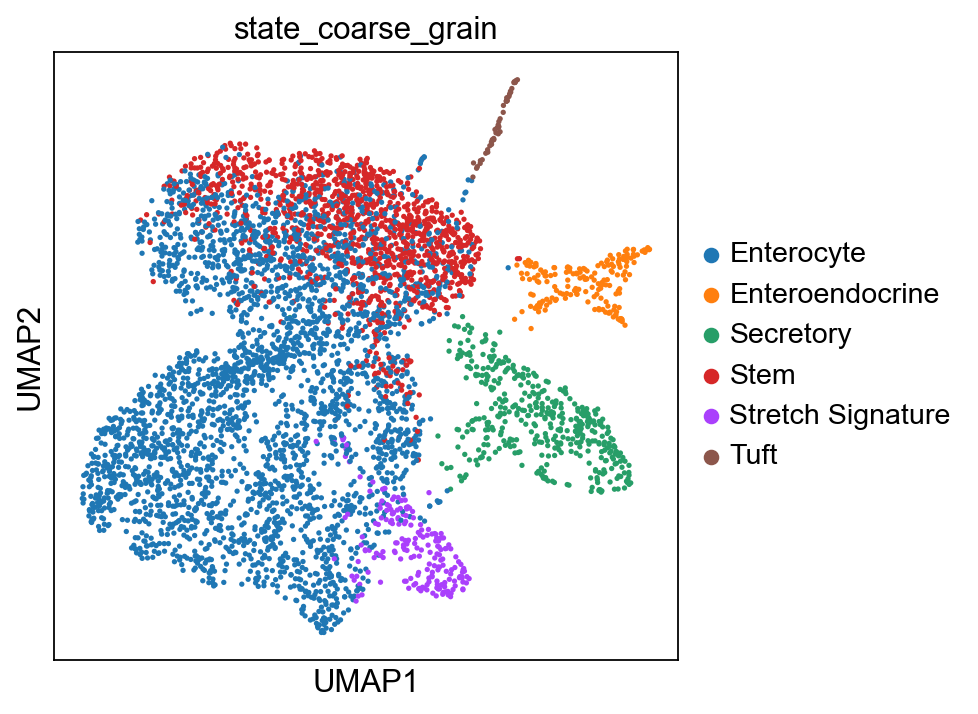

In [64]:
sc.pl.umap(adata, color='state_coarse_grain') 

# using scanpy to plot (see custom plotting in cell below)
# you can change colors using this plotting function
# and accessing the adata.uns['state_coarse_grain_colors'] dictionary

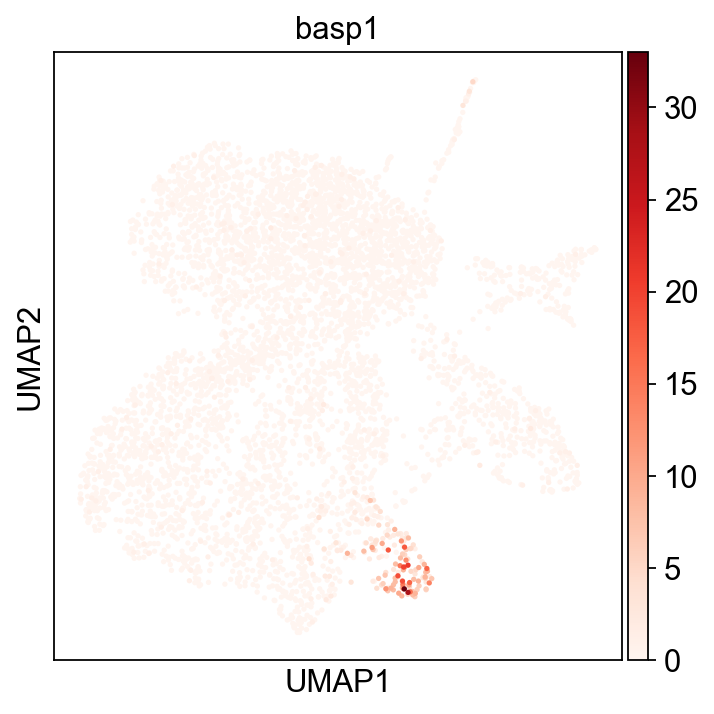

In [65]:
# repeat for genes of interest
# see figures folder for examples of stretch-response genes
# add a list of genes to save a set of plots 
sc.pl.umap(adata, color='basp1', cmap='Reds', save='_basp1_perturbations') 

<a id='6A'></a>

## Coarse grained states - Figure 6A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

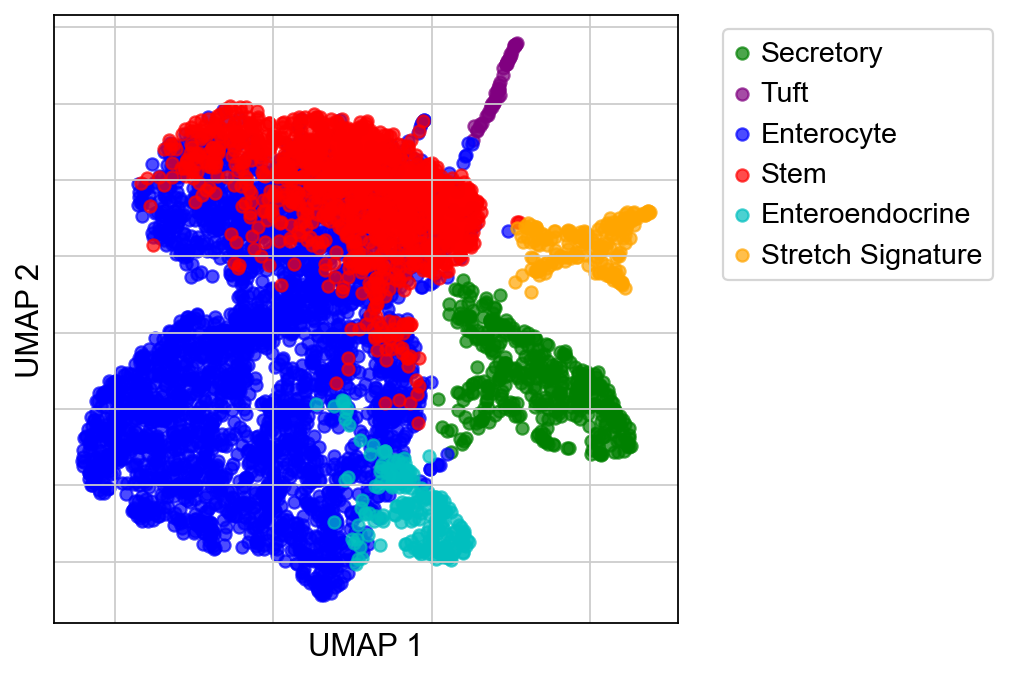

In [66]:
#Note that the built-in function for making the umap plots from scanpy is not working with this new annotation
#so using a more manual approach to plotting this data

# making copies of xy coords and labels
umap_xy = adata.obsm['X_umap']
labels_umap = adata.obs['state_coarse_grain']

plt.rcParams['figure.figsize'] = (5,5)


# this line hides x-labels and xticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# this line hides y-labels and yticks
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.scatter(umap_xy[labels_umap == 'Secretory', 0], umap_xy[labels_umap == 'Secretory', 1], alpha=0.7, color='g', s=30)
plt.scatter(umap_xy[labels_umap == 'Tuft', 0], umap_xy[labels_umap == 'Tuft', 1], alpha=0.7, color='purple', s=30)
plt.scatter(umap_xy[labels_umap == 'Enterocyte', 0], umap_xy[labels_umap == 'Enterocyte', 1], alpha=0.7, color='blue', s=30)
plt.scatter(umap_xy[labels_umap == 'Stem', 0], umap_xy[labels_umap == 'Stem', 1], alpha=0.7, color='r', s=30)
plt.scatter(umap_xy[labels_umap == 'Stretch Signature', 0], umap_xy[labels_umap == 'Stretch Signature', 1], alpha=0.7, color='c', s=30)
plt.scatter(umap_xy[labels_umap == 'Enteroendocrine', 0], umap_xy[labels_umap == 'Enteroendocrine', 1], alpha=0.7, color='orange', s=30)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(['Secretory', 'Tuft', 'Enterocyte', 'Stem', 'Enteroendocrine', 'Stretch Signature'], bbox_to_anchor=(1.05, 1))

plt.savefig(f'{plot_dir}/umap_merge_states_coarse_grained_perturbations.eps', bbox_inches='tight')

<a id='S4A'></a>

## Plot each treatment cluster - Figure S4A

In [67]:
new_obs = {}

for cell in list(adata.obs.index):
    if adata.obs['treatment'].loc[cell] == 'Forskolin' and adata.obs['duration'].loc[cell] == '12h':
        new_obs[cell] = 'Forskolin 12h'
    if adata.obs['treatment'].loc[cell] == 'DMSO' and adata.obs['duration'].loc[cell] == '12h':
        new_obs[cell] = 'DMSO 12h'
    if adata.obs['treatment'].loc[cell] == 'CFTR-inh172' and adata.obs['duration'].loc[cell] == '36h':
        new_obs[cell] = 'CFTR-inh172 36h'
    if adata.obs['treatment'].loc[cell] == 'DMSO' and adata.obs['duration'].loc[cell] == '36h':
        new_obs[cell] = 'DMSO 36h'


In [68]:
adata.obs['treatment verbose'] = pd.Series(new_obs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

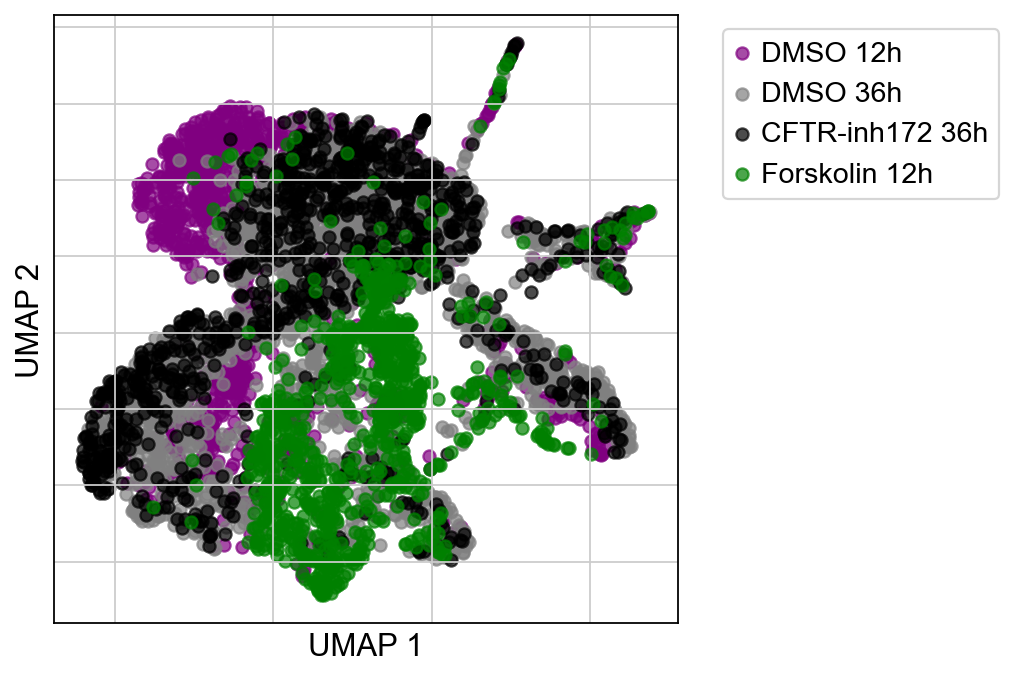

In [69]:
#Note that the built-in function for making the umap plots from scanpy is not working with this new annotation
#so using a more manual approach to plotting this data

# making copies of xy coords and labels
umap_xy = adata.obsm['X_umap']
labels_umap = adata.obs['treatment verbose']

plt.rcParams['figure.figsize'] = (5,5)


# this line hides x-labels and xticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# this line hides y-labels and yticks
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


plt.scatter(umap_xy[labels_umap == 'DMSO 12h', 0], umap_xy[labels_umap == 'DMSO 12h', 1], alpha=0.7, color='purple', s=30)
plt.scatter(umap_xy[labels_umap == 'DMSO 36h', 0], umap_xy[labels_umap == 'DMSO 36h', 1], alpha=0.7, color='gray', s=30)
plt.scatter(umap_xy[labels_umap == 'CFTR-inh172 36h', 0], umap_xy[labels_umap == 'CFTR-inh172 36h', 1], alpha=0.7, color='black', s=30)
plt.scatter(umap_xy[labels_umap == 'Forskolin 12h', 0], umap_xy[labels_umap == 'Forskolin 12h', 1], alpha=0.7, color='green', s=30)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(['DMSO 12h', 'DMSO 36h','CFTR-inh172 36h','Forskolin 12h'], bbox_to_anchor=(1.05, 1))

plt.savefig(f'{plot_dir}/umap_merge_treatment_coarse_grained_perturbations.eps', bbox_inches='tight')

<a id='spring'></a>

*** ***

## Save data files

### Save metadata, including UMAP coordinates 

In [70]:
umap_coords = pd.DataFrame(adata.obsm['X_umap']).rename(columns={0:'UMAP_X', 1:'UMAP_Y'})

In [71]:
adata.obs['UMAP_X'] = list(umap_coords['UMAP_X'])

In [72]:
adata.obs['UMAP_Y'] = list(umap_coords['UMAP_Y'])

In [73]:
adata.obs.to_excel('perturbations_metadata.xlsx')

### Save annotated data

In [74]:
sc.write(f'{h5ad_dir}/adata_merged_annotated_perturbations.h5ad', adata)

... storing 'treatment verbose' as categorical


In [75]:
adata = sc.read(f'{h5ad_dir}/adata_merged_annotated_perturbations.h5ad')

## Export to SPRING

<div class="alert alert-info">
    
***As described in: Caleb Weinreb, Samuel Wolock, Allon M Klein, SPRING: a kinetic interface for visualizing high dimensional single-cell expression data, Bioinformatics, Volume 34, Issue 7, 01 April 2018, Pages 1246–1248, https://doi.org/10.1093/bioinformatics/btx792***
    
</div>

In [76]:
adata.obs['state'] = adata.obs['state_coarse_grain']

In [77]:
categorical_vars = ['state', 'treatment', 'duration', 'batch', 'replicate', 'leiden', 'phase', 'included after filter', 'Library Name']
for k in categorical_vars:
    adata.obs[k] = pd.Categorical(adata.obs[k])

In [78]:
adata.obs.columns

Index(['treatment', 'duration', 'batch', 'replicate', 'reads', 'aligned reads',
       'n_counts', 'included after filter', 'Library Name',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'percent_mito', 'mito_frac',
       'percent_ribo', 'ribo_frac', 'percent_ncrna', 'ncrna_frac', 'n_genes',
       'S_score', 'G2M_score', 'phase', 'leiden',
       'gene_score_z_state_marker_Enteroendocrine',
       'gene_score_state_marker_Enteroendocrine',
       'gene_score_z_state_marker_Stem', 'gene_score_state_marker_Stem',
       'gene_score_z_state_marker_Tuft', 'gene_score_state_marker_Tuft',
       'gene_score_z_state_marker_Stretch Signature',
       'gene_score_state_marker_Stretch Signature',
       'gene_score_z_state_marker_Enterocyte',
       'gene_score_state_marker_Enterocyte',
       'gene_score_z

In [81]:
del adata.raw #since you delete the raw dataframe here, make sure you save BEFORE running SPRING!!

In [80]:
#you will need to drag from this folder to the Spring Dev folder in order to actually run it!!
spring_plot_dir = spring_main+'/murine_intestinal_organoid_inflation_perturbation_expt'
sc.external.exporting.spring_project(
    adata, 
    project_dir=spring_plot_dir, 
    subplot_name='all_cells',
    embedding_method='umap',
    cell_groupings=categorical_vars,
    custom_color_tracks=['gene_score_z_state_marker_Enteroendocrine',
       'gene_score_z_state_marker_Stretch Signature',
        'gene_score_z_state_marker_Secretory',
        'gene_score_z_state_marker_Stem',
        'gene_score_z_state_marker_Tuft',
       'gene_score_z_state_marker_Enterocyte', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'percent_mito', 'mito_frac',
       'percent_ribo', 'n_genes', 'S_score', 'G2M_score'],
    overwrite=True
)
#url (after navigating to SPRING_dev): 
#new: http://localhost:8000/springViewer_1_6_dev.html?data/murine_intestinal_organoid_inflation_perturbation_expt/all_cells

Writing subplot to _spring/murine_intestinal_organoid_inflation_perturbation_expt/all_cells


<a id='save_all'></a>